# Zillow Clustering Project 

##### Imports:

In [1]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Data Handling
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Statistical Tests
import scipy.stats as stats

# Visualizing
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from sklearn.model_selection import learning_curve

# Wrangle file to acquire and clean Zillow data
import wrangle_zillow as wr
import sklearn.preprocessing

# Explore file
import explore as ex

# Models
import zillow_models as zm

## Acquire:

In [2]:
zillow = wr.wrangle_zillow()
zillow.head(3)

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,yearbuilt,taxvaluedollarcnt,logerror,transactiondate,heatingorsystemdesc,county
0,3.5,4.0,3100.0,6059.0,33634931.0,-117869207.0,1998.0,1023282.0,0.025595,2017-01-01,None,Orange
1,1.0,2.0,1465.0,6111.0,34449266.0,-119281531.0,1967.0,464000.0,0.055619,2017-01-01,None,Ventura
2,2.0,3.0,1243.0,6059.0,33886168.0,-117823170.0,1962.0,564778.0,0.005383,2017-01-01,None,Orange


In [3]:
zillow.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70910 entries, 0 to 77380
Data columns (total 12 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bathroomcnt                   70910 non-null  float64
 1   bedroomcnt                    70910 non-null  float64
 2   calculatedfinishedsquarefeet  70910 non-null  float64
 3   fips                          70910 non-null  float64
 4   latitude                      70910 non-null  float64
 5   longitude                     70910 non-null  float64
 6   yearbuilt                     70910 non-null  float64
 7   taxvaluedollarcnt             70910 non-null  float64
 8   logerror                      70910 non-null  float64
 9   transactiondate               70910 non-null  object 
 10  heatingorsystemdesc           70910 non-null  object 
 11  county                        70910 non-null  object 
dtypes: float64(9), object(3)
memory usage: 7.0+ MB


### Train, Validate, Test Split

In [4]:
train, validate, test = wr.train_validate_test_split(zillow)
print("train observations: ", train.size)
print("validate observations: ", validate.size)
print("test observations: ", test.size)

train observations:  510552
validate observations:  170184
test observations:  170184


## Explore:

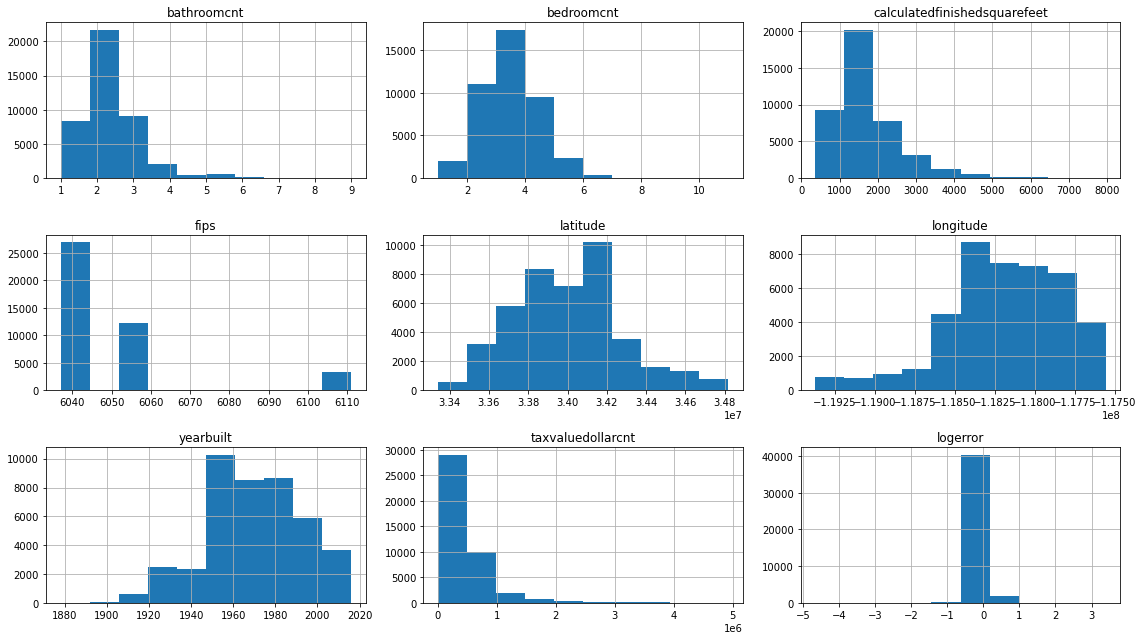

In [5]:
train.hist(figsize=(16,9))
plt.tight_layout()
plt.show()

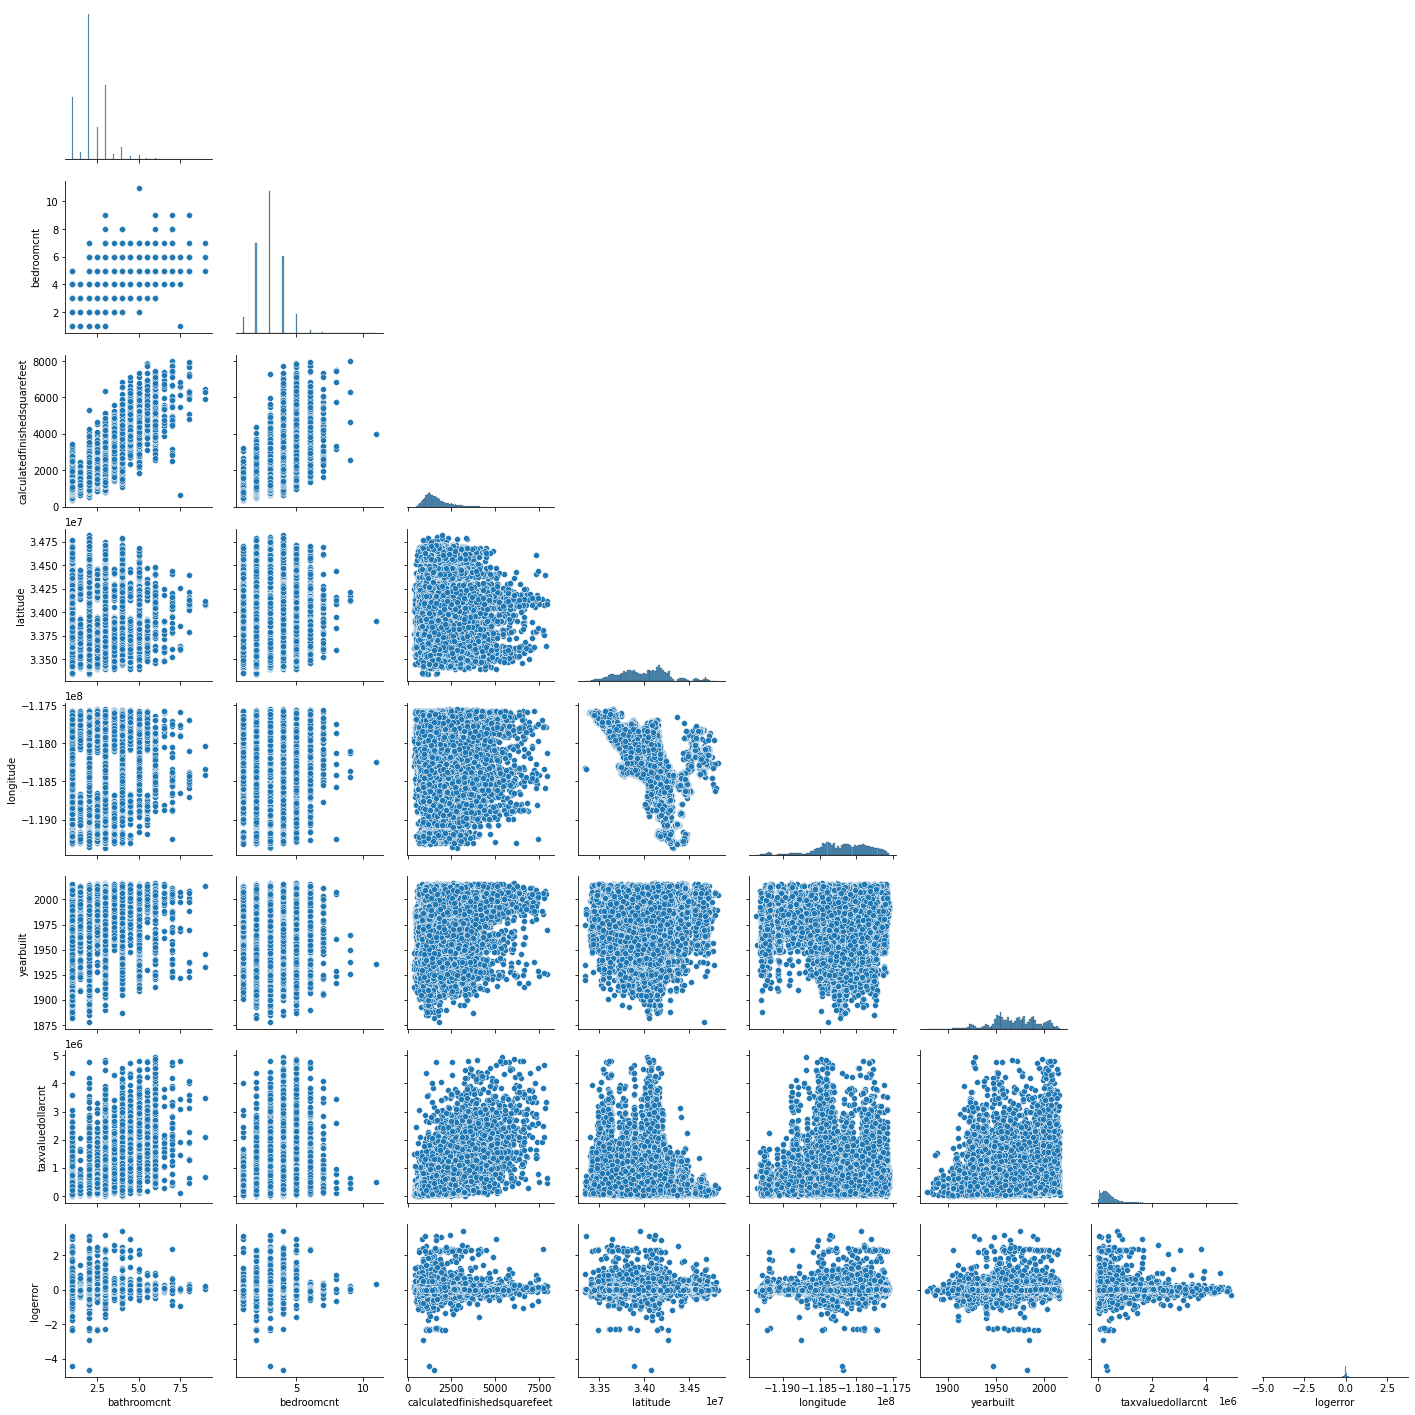

In [6]:
sns.pairplot(train.drop(columns='fips'), corner=True)
plt.show()

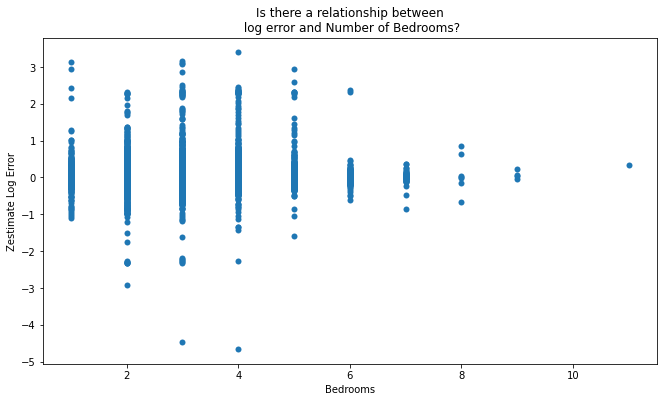

In [7]:
# Plot of log error vs number of bedrooms
f, ax = plt.subplots(figsize=(11, 6))
sns.scatterplot(x="bedroomcnt", y="logerror",
                sizes=(1, 8), linewidth=0,
                data=train, ax=ax)
plt.title('Is there a relationship between\n log error and Number of Bedrooms?')
plt.xlabel('Bedrooms')
plt.ylabel('Zestimate Log Error')
ax.xaxis.set_major_formatter('{:.0f}'.format)
plt.show()

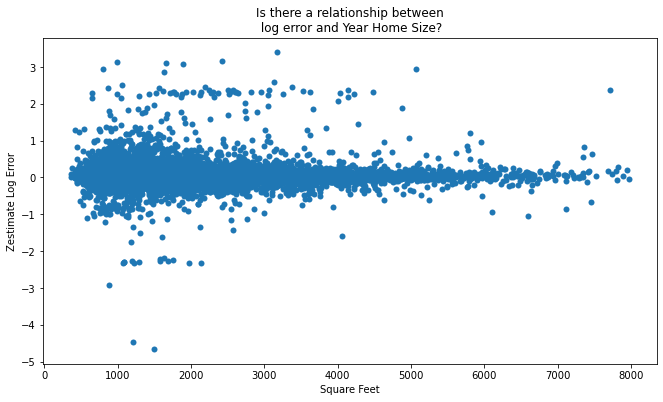

In [8]:
# Plot of log error vs square feet
f, ax = plt.subplots(figsize=(11, 6))
sns.scatterplot(x="calculatedfinishedsquarefeet", y="logerror",
                sizes=(1, 8), linewidth=0,
                data=train, ax=ax)
plt.title('Is there a relationship between\n log error and Year Home Size?')
plt.xlabel('Square Feet')
plt.ylabel('Zestimate Log Error')
ax.xaxis.set_major_formatter('{:.0f}'.format)
plt.show()

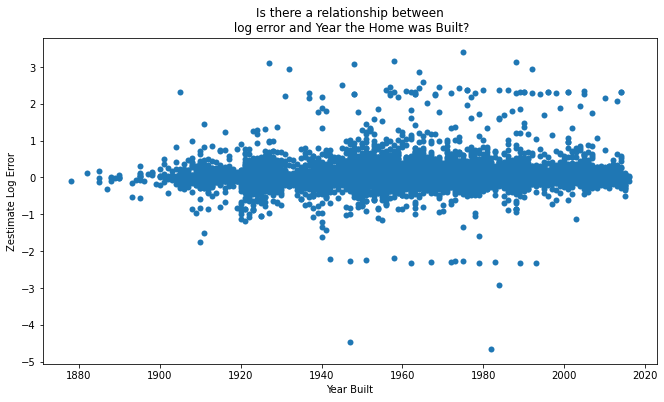

In [9]:
# Plot of log error vs year built
f, ax = plt.subplots(figsize=(11, 6))
sns.scatterplot(x="yearbuilt", y="logerror",
                sizes=(1, 8), linewidth=0,
                data=train, ax=ax)
plt.title('Is there a relationship between\n log error and Year the Home was Built?')
plt.xlabel('Year Built')
plt.ylabel('Zestimate Log Error')
ax.xaxis.set_major_formatter('{:.0f}'.format)
plt.show()

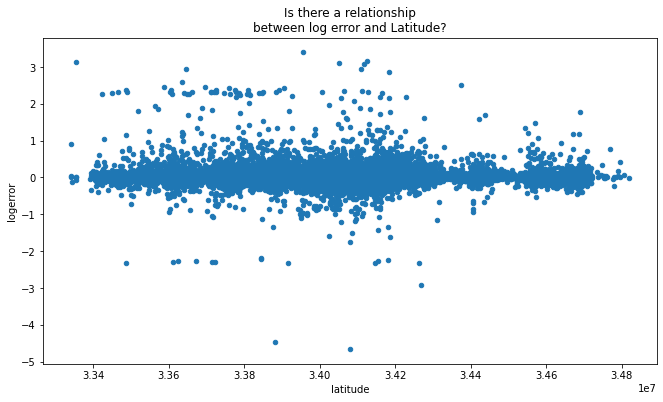

In [10]:
train.plot.scatter(
    x="latitude",
    y="logerror",
    title='Is there a relationship\nbetween log error and Latitude?',
    figsize=(11, 6)
)
plt.show()

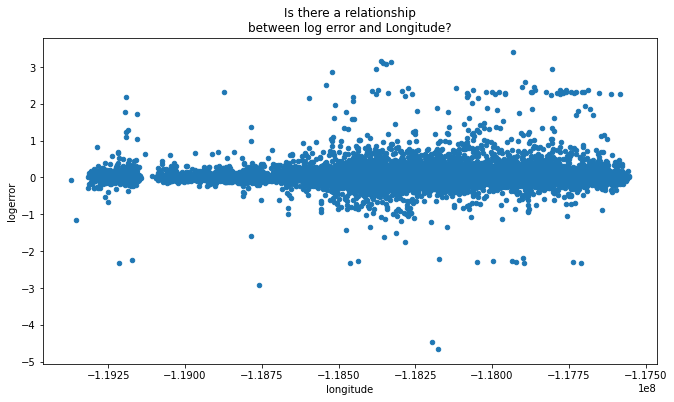

In [11]:
train.plot.scatter(
    x="longitude",
    y="logerror",
    title='Is there a relationship\nbetween log error and Longitude?',
    figsize=(11, 6),
)
plt.show()

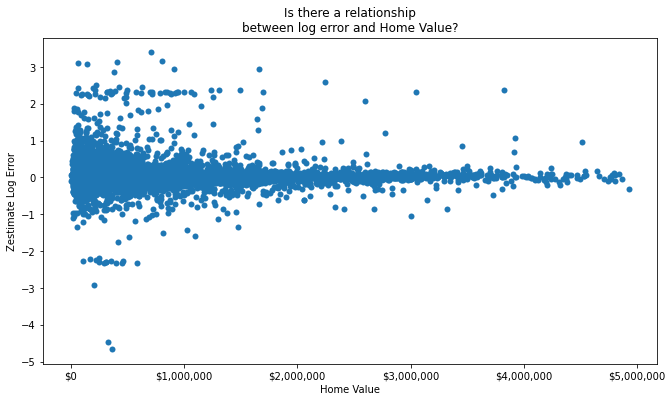

In [12]:
# Plot of log error vs home value
f, ax = plt.subplots(figsize=(11, 6))
sns.scatterplot(x="taxvaluedollarcnt", y="logerror",
                sizes=(1, 8), linewidth=0,
                data=train, ax=ax)
plt.title('Is there a relationship\nbetween log error and Home Value?')
plt.xlabel('Home Value')
plt.ylabel('Zestimate Log Error')
ax.xaxis.set_major_formatter('${:,.0f}'.format) 

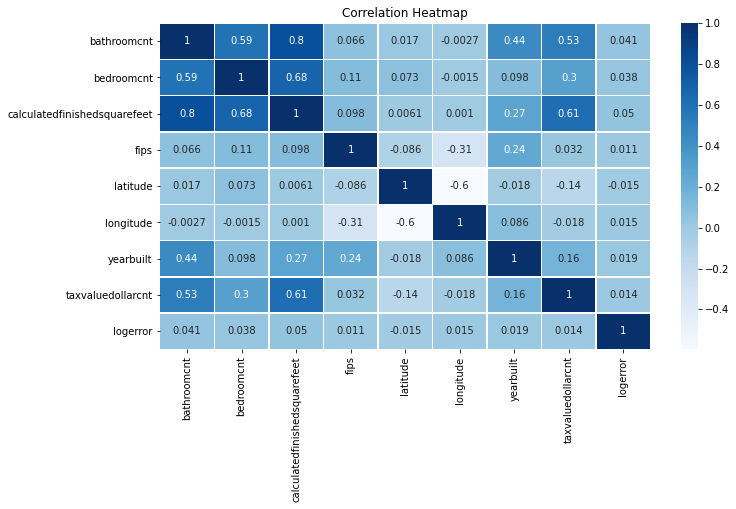

In [13]:
plt.figure(figsize=(11,6))
sns.heatmap(train.corr(), cmap='Blues', annot=True, linewidth=0.5)
plt.title('Correlation Heatmap')
plt.show()

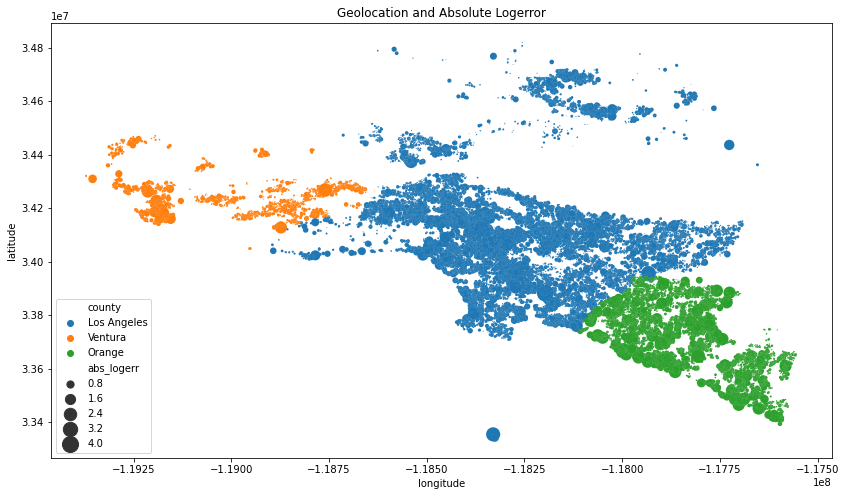

In [14]:
train['abs_logerr'] = train.logerror.apply(lambda x: x if x >= 0 else -x)
# Plot of error using lat/long
plt.figure(figsize=(14,8))
sns.scatterplot(x='longitude', y='latitude', hue='county', size='abs_logerr', sizes=(0,300), data=train)
plt.legend()
plt.title('Geolocation and Absolute Logerror')
plt.show()

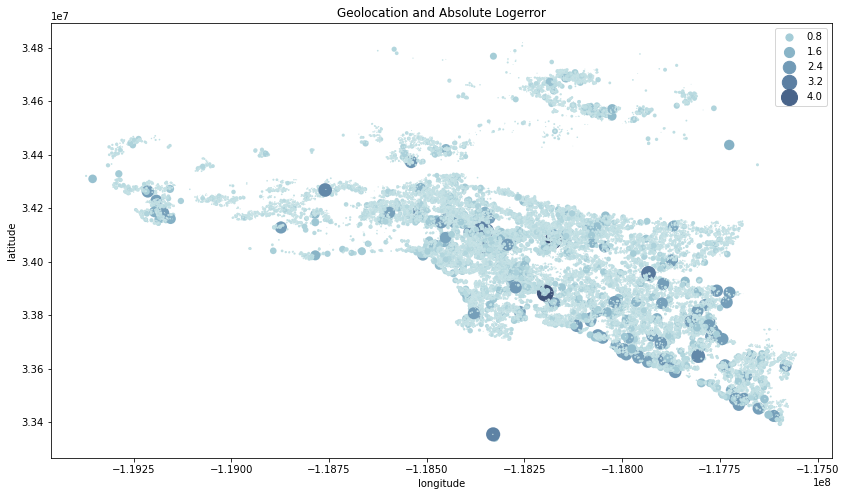

In [15]:
# Plot of error using lat/long
plt.figure(figsize=(14,8))
sns.scatterplot(x='longitude', y='latitude', hue='abs_logerr', palette="ch:r=-.2,d=.3", size='abs_logerr', sizes=(0,300), data=train)
plt.legend()
plt.title('Geolocation and Absolute Logerror')
plt.show()

##### Takeaways:
- There seems to be bands of clusters in log error vs above categories
- Lat Long seems to be the most promising to explore via clustering
- Then potentially sqft and beadroom/bathroom count

### Statistics

In [16]:
train = train.drop(columns='abs_logerr')
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42546 entries, 28420 to 47816
Data columns (total 12 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bathroomcnt                   42546 non-null  float64
 1   bedroomcnt                    42546 non-null  float64
 2   calculatedfinishedsquarefeet  42546 non-null  float64
 3   fips                          42546 non-null  float64
 4   latitude                      42546 non-null  float64
 5   longitude                     42546 non-null  float64
 6   yearbuilt                     42546 non-null  float64
 7   taxvaluedollarcnt             42546 non-null  float64
 8   logerror                      42546 non-null  float64
 9   transactiondate               42546 non-null  object 
 10  heatingorsystemdesc           42546 non-null  object 
 11  county                        42546 non-null  object 
dtypes: float64(9), object(3)
memory usage: 4.2+ MB


### Scaling

In [17]:
# Scale the datasets
column = ['fips', 'transactiondate', 'heatingorsystemdesc', 'county']
scaler = sklearn.preprocessing.MinMaxScaler()
cols = train.drop(columns=column).columns.tolist()

# .copy() makes a proper copy
# this is an alternative to wrapping the scaled numpy array in a pd.Dataframe()
train_scaled = train.copy()
validate_scaled = validate.copy()
test_scaled = test.copy()

# apply our scaler (fit only on train!)
train_scaled[cols] = scaler.fit_transform(train[cols])
validate_scaled[cols] = scaler.transform(validate[cols])
test_scaled[cols] = scaler.transform(test[cols])

train_scaled = train_scaled.drop(columns=column)
validate_scaled = validate_scaled.drop(columns=column)
test_scaled = test_scaled.drop(columns=column)

In [18]:
train_scaled.head(2)


,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,latitude,longitude,yearbuilt,taxvaluedollarcnt,logerror
28420,0.125,0.1,0.074901,0.573464,0.502856,0.826087,0.028647,0.580490
66765,0.000,0.1,0.147043,0.441294,0.594425,0.224638,0.027425,0.585111


## Initial Regression Models

In [19]:
X_train, y_train, X_validate, y_validate, X_test, y_test = zm.zillow_xy(train_scaled, validate_scaled, test_scaled)

In [20]:
zm.model_compare(X_train, y_train, X_validate, y_validate)

Baseline RMSE using Mean
Train/In-Sample:  0.02 
Validate/Out-of-Sample:  0.02
RMSE for OLS using LinearRegression
Training/In-Sample:  0.02 
Validation/Out-of-Sample:  0.02
RMSE for Lasso + Lars
Training/In-Sample:  0.02 
Validation/Out-of-Sample:  0.02
RMSE for GLM using Tweedie, power= 0  & alpha= 0 
Training/In-Sample:  0.02 
Validation/Out-of-Sample:  0.02
RMSE for GLM using Tweedie, power= 1  & alpha= 0 
Training/In-Sample:  0.02 
Validation/Out-of-Sample:  0.02
RMSE for Polynomial Model, degrees= 2 
Training/In-Sample:  0.02044008919828303 
Validation/Out-of-Sample:  0.02083459562147694
RMSE for Polynomial Model, degrees= 3 
Training/In-Sample:  0.020383432832114315 
Validation/Out-of-Sample:  0.020907425493663284


,model,RMSE_validate,r^2_validate
0,mean_baseline,0.0,0.000000
1,OLS Regressor,0.0,-0.000075
2,lasso_alpha_1,0.0,0.000000
3,GLM Normal,0.0,-0.000168
4,GLM Poisson,0.0,-0.000306
5,Ploynomial 2deg,0.0,0.000690
6,Ploynomial 3deg,0.0,-0.006295


## Clustering

##### Scaling: